# Overview

In [Multilayer perceptron implement optimization](https://www.kaggle.com/code/aisuko/multilayer-perceptron-implement-optimization), we got final result of our loss function is `2.3` on our tiny model. 

However, we could have millions of parameters and as the capacity of the neural networks grows. It becomes more and more capable of overfitting our training set which means is that the loss on the training set on the data that we're training on will become extreamly low as zero. It's working reall well but you try to sample from it you will basically only get examples exactly as they are in the training set, you won't get any new data in additiona to that if you try to evaluate the loss on some withheld names or other words you will actually see that the loss on those can be very high.

So, it's not a good model. How can we make it better?

# Split the dataset
* **training(80%)** -> It's used to optimize the parameters of the model
* **dev/validation(10%)** -> Thet're used for development overall hyper parameters, like, the size of hiddenlayer and embedding.
* **test(10%)** -> They're used to evaluate the performance of the model at the end. So, we're only evaluating the loss on the test very, very, very few times because every single time you evaluate your test loss and you learn something from it. You are basically starting to also train on the test split otherwise you risk overfitting to it.


# Build the dataset

In [1]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt

words=open('/kaggle/input/character-lm-without-framework/names.txt', 'r').read().splitlines()

# build the vocabulary of characters and mappings to/from integers
chars=sorted(list(set(''.join(words))))
stoi={s:i+1 for i,s in enumerate(chars)}
stoi['.']=0
itos={i:s for s,i in stoi.items()}
print(itos)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}


In [2]:
import random

def build_dataset(words):
    block_size=3 # context length: how many characters do we take to predict the next one?
    X,Y=[],[]
    for w in words:
        context=[0]*block_size
        for ch in w+'.':
            ix=stoi[ch]
            X.append(context)
            Y.append(ix)
            context=context[1:]+[ix]
            
    X=torch.tensor(X)
    Y=torch.tensor(Y)
    print(X.shape, Y.shape)
    return X,Y


random.seed(42)
random.shuffle(words)
n1=int(0.8*len(words))
n2=int(0.9*len(words))

Xtr, Ytr=build_dataset(words[:n1])
Xdev, Ydev=build_dataset(words[n1:n2])
Xte, Yte=build_dataset(words[n2:])

torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


# Setting the neural net

In [3]:
# definition of neural network
g=torch.Generator().manual_seed(2147483647)

C=torch.randn((27,2), generator=g)
W1=torch.randn((6, 100), generator=g)
b1=torch.randn(100, generator=g)
W2=torch.randn((100, 27), generator=g)
b2=torch.randn(27, generator=g)
parameters=[C, W1, b1, W2, b2]

print(sum(p.nelement() for p in parameters))

for p in parameters:
    p.requires_grad = True

# define a range of learning rate
lre=torch.linspace(-3, 0, 1000)
lrs=10**lre

lri=[]
lossi=[]

# training process
for i in range(1000):
    
    # minibatch construct
    ix=torch.randint(0, Xtr.shape[0], (32,))
    
    # forward pass
    emb=C[Xtr[ix]]
    h=torch.tanh(emb.view(-1, 6)@ W1+b1)
    logits=h @ W2+b2
    loss=F.cross_entropy(logits, Ytr[ix])
#     print(loss.item())
    
    # backward pass
    for p in parameters:
        p.grad=None
    loss.backward()
    
    # update
    lr=0.1
    for p in parameters:
        p.data+=-lr*p.grad

    # track stats
    lri.append(lre[i]) # we track the exponent
    lossi.append(loss.item())

3481


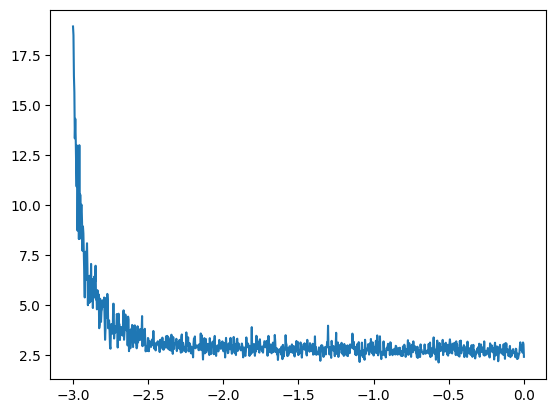

In [4]:
plt.plot(lri, lossi)

In [5]:
emb=C[Xdev]
h=torch.tanh(emb.view(-1, 6)@W1+b1)
logits=h@W2+b2
loss=F.cross_entropy(logits, Ydev)
loss

tensor(2.6782, grad_fn=<NllLossBackward0>)

# Doing decay loss again

In [6]:
lri=[]
lossi=[]

# training process
for i in range(800):
    
    # minibatch construct
    ix=torch.randint(0, Xtr.shape[0], (32,))
    
    # forward pass
    emb=C[Xtr[ix]]
    h=torch.tanh(emb.view(-1, 6)@ W1+b1)
    logits=h @ W2+b2
    loss=F.cross_entropy(logits, Ytr[ix])
#     print(loss.item())
    
    # backward pass
    for p in parameters:
        p.grad=None
    loss.backward()
    
    # update
    lr=0.01
    for p in parameters:
        p.data+=-lr*p.grad

    # track stats
    lri.append(lre[i]) # we track the exponent
    lossi.append(loss.item())

In [7]:
emb=C[Xdev]
h=torch.tanh(emb.view(-1, 6)@W1+b1)
logits=h@W2+b2
loss=F.cross_entropy(logits, Ydev)
loss

tensor(2.5626, grad_fn=<NllLossBackward0>)

# Check the loss on the training dataset

In [8]:
emb=C[Xtr]
h=torch.tanh(emb.view(-1, 6)@W1+b1)
logits=h@W2+b2
loss=F.cross_entropy(logits, Ytr)
loss

tensor(2.5694, grad_fn=<NllLossBackward0>)

# Conclusion

So, we can see we got the almost same loss on both the training and development datasets. So, we're not over fitting the model. We called it underfitting.

# Acknowledgement

* https://youtu.be/TCH_1BHY58I?si=4WxPsYcK6hXX_9NS
* https://www.kaggle.com/code/aisuko/multilayer-perceptron-implement-optimization
* https://www.kaggle.com/code/aisuko/multilayer-perceptron-implement
* https://www.kaggle.com/code/aisuko/character-lm-without-framework